In [1]:
import os, zipfile
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from preprocessing import SelectMajorCategories
from visualizations import *
from language import *

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Montando o setup do Kaggle

In [2]:
if 'google.colab' in str(get_ipython()):
    os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle/"
    on_colab = True
    ! pip install kaggle --upgrade
else:
    os.environ['KAGGLE_CONFIG_DIR'] = "../../Kaggle/"
    on_colab = False

In [4]:
# Downloading and extracting the data from Kaggle
if on_colab:
    dataset_folder = "./"
    ! kaggle competitions download -c i2a2-nlp-2021-sentiment-analysis
    ! unzip -q i2a2-nlp-2021-sentiment-analysis.zip -d "./i2a2-nlp-2021-sentiment-analysis/"
    ! rm i2a2-nlp-2021-sentiment-analysis.zip
else:
    dataset_folder = "C:\\Users\\weldl\\datasets\\i2a2-nlp-2021-sentiment-analysis"
    if not os.path.isdir(dataset_folder):
        ! kaggle competitions download -c i2a2-nlp-2021-sentiment-analysis -p "C:\\Users\\weldl\\datasets"
        # Create a ZipFile Object and load sample.zip in it
        zip_file = dataset_folder + ".zip"
        with ZipFile(zip_file, 'r') as zipObj:
           # Extract all the contents of zip file in different directory
           zipObj.extractall(dataset_folder)
        os.remove(zip_file)

In [5]:
df_train = pd.read_csv(os.path.join(dataset_folder, "train.csv"), low_memory=False)
df_test = pd.read_csv(os.path.join(dataset_folder, "test.csv"), low_memory=False)

# Data Preparation:

In [6]:
target_col = 'rating'

In [7]:
x_train = df_train.drop(columns=[target_col])
y_train = df_train[[target_col]]

x_test = df_test

# Pre-processing

In [8]:
# Selecting the major categories in the categorical features:
cat_features = ['reviewer_gender', 'reviewer_state', 'product_brand', 'site_category_lv1', 'site_category_lv2']
sel = SelectMajorCategories(columns=cat_features, perc=0.01)
sel.fit(x_train)

x_train = sel.transform(x_train)
x_test = sel.transform(x_test)

C:\Users\weldl\Google Drive\Kaggle\i2a2-nlp-2021-sentiment-analysis\preprocessing.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df_[col][~np.isin(x_df[col], self.major_categories[col])] = self.minor_label


In [9]:
# TfidfVectorizer:
pt_stp_words = stopwords.words('portuguese')
corpus = x_train['review_title'].values
vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words=pt_stp_words,
                             max_features=100, ngram_range=(1, 3))
vectorizer.fit(corpus)

c:\users\weldl\miniconda3\envs\i2a2-nlp\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ate', 'eramos', 'estao', 'estavamos', 'estiveramos', 'estivessemos', 'foramos', 'fossemos', 'ha', 'hao', 'houveramos', 'houverao', 'houveriamos', 'houvessemos', 'ja', 'nao', 'sao', 'sera', 'serao', 'seriamos', 'so', 'tambem', 'tera', 'terao', 'teriamos', 'tinhamos', 'tiveramos', 'tivessemos', 'voce', 'voces'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


TfidfVectorizer(max_features=100, ngram_range=(1, 3),
                stop_words=['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em',
                            'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se',
                            'na', 'por', 'mais', 'as', 'dos', 'como', 'mas',
                            'ao', 'ele', 'das', 'à', 'seu', 'sua', ...],
                strip_accents='unicode')

In [10]:
x_train_tfidf = vectorizer.transform(x_train['review_title'])
tfidf_cols = [f'tfidf_review_title_{i}' for i in range(x_train_tfidf.shape[1])]
x_train_tfidf = pd.DataFrame(x_train_tfidf.toarray(), columns=tfidf_cols)
x_train = pd.concat([x_train, x_train_tfidf], axis=1)

x_test_tfidf = vectorizer.transform(x_test['review_title'])
x_test_tfidf = pd.DataFrame(x_test_tfidf.toarray(), columns=tfidf_cols)
x_test = pd.concat([x_test, x_test_tfidf], axis=1)

In [11]:
# Encoding:

# Features groups:
cat_features = ['reviewer_gender', 'reviewer_state', 'product_brand', 'site_category_lv1', 'site_category_lv2']
num_float_features = ['reviewer_birth_year']
passthrough_features = [] + tfidf_cols

# Features transformers:
cat_transformer = ('cat', Pipeline([('cat_imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='none')),
                                    ('one-hot', OneHotEncoder(handle_unknown='ignore'))]), cat_features)
num_float_transformer = ('num_float', Pipeline([('num_float_imputer', SimpleImputer(missing_values=np.nan, strategy='mean'))]), num_float_features)
passthrough_transformer = ('passthrough', 'passthrough', passthrough_features)

transformers = [cat_transformer, num_float_transformer, passthrough_transformer]
feat_encoding = ColumnTransformer(transformers, remainder='drop')

In [12]:
# Features creation:

In [13]:
# Features Selection:

In [14]:
# Pre-processing pipeline:
preprocessor = Pipeline([('features encoding', feat_encoding)])

In [15]:
x_train_encoded = preprocessor.fit_transform(x_train)
x_test_encoded = preprocessor.transform(x_test.loc[:, x_train.columns])

# Model Training

In [16]:
n_jobs = 4

In [17]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [5, 10, 20, 30, 40, 50],
    'max_features': ["auto"],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [8, 10, 12, 14, 16],
    'n_estimators': [1, 5, 10, 20, 30, 40, 50],
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
clf = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                         cv=5, n_jobs=n_jobs, verbose=2, n_iter=10)

In [18]:
clf.fit(x_train_encoded, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\users\weldl\miniconda3\envs\i2a2-nlp\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 20, 30, 40, 50],
                                        'max_features': ['auto'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_samples_split': [8, 10, 12, 14,
                                                              16],
                                        'n_estimators': [1, 5, 10, 20, 30, 40,
                                                         50]},
                   verbose=2)

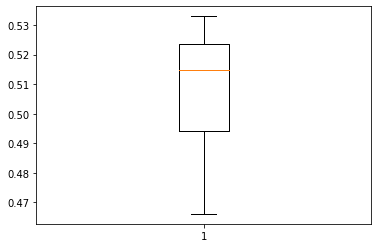

In [19]:
estimators_list = [clf]
plot_estimators_cvperf(estimators_list)

In [20]:
clf.best_estimator_

RandomForestClassifier(max_depth=40, min_samples_leaf=10, min_samples_split=8,
                       n_estimators=40)

In [21]:
# Re-fiting the best estimator in all data:
model = clf.best_estimator_.fit(x_train_encoded, y_train)
model

<ipython-input-21-e725a87dad6c>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = clf.best_estimator_.fit(x_train_encoded, y_train)


RandomForestClassifier(max_depth=40, min_samples_leaf=10, min_samples_split=8,
                       n_estimators=40)

# Submission

In [22]:
rating = model.predict(x_test_encoded)
df_submission = pd.DataFrame({"id": [i for i in range(x_test_encoded.shape[0])],
                              "rating": rating})
df_submission

,id,rating
0,0,4
1,1,5
2,2,4
3,3,5
4,4,1
...,...,...
39707,39707,5
39708,39708,5
39709,39709,4
39710,39710,4


In [23]:
submition_file = './submition_file.csv'
df_submission.to_csv(submition_file, index=False)

In [24]:
# !kaggle competitions list

In [25]:
# !kaggle competitions submit -c i2a2-nlp-2021-sentiment-analysis -f submition_file.csv -m "Model 02: tfidf vectorizer on review_title"